## Predict using LSTM

In [1]:
import numpy as np
import math
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

import keras
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf

import pandas as pd
import pandas_datareader as web

Using TensorFlow backend.


In [9]:
#Start data and end date
start = datetime.datetime(2019,3,9)
end = datetime.datetime(2020,3,12)

#load the dataset
df = web.DataReader('5225.KL','yahoo',start,end)
df.to_csv('stock2_IHH.csv')
df = pd.read_csv('stock2_IHH.csv')

df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
247,2020-03-06,5.81,5.56,5.56,5.75,3291700,5.75
248,2020-03-09,5.77,5.54,5.65,5.69,8292000,5.69
249,2020-03-10,5.74,5.56,5.69,5.59,8510600,5.59
250,2020-03-11,5.64,5.57,5.59,5.59,6572000,5.59
251,2020-03-12,5.62,5.42,5.59,5.56,7043700,5.56


In [3]:
#Find the row with max close price for documentation
df.iloc[df['Close'].idxmax()]

Date         2019-12-18
High               5.93
Low                5.45
Open                5.5
Close              5.93
Volume          4390100
Adj Close          5.93
Name: 193, dtype: object

In [4]:
#Find the row with minimum close price for documentation
df.iloc[df['Close'].idxmin()]

Date         2019-11-14
High                5.4
Low                5.24
Open               5.39
Close              5.24
Volume          8804800
Adj Close          5.24
Name: 169, dtype: object

In [90]:
#convert date column to datetitme and set axis to date and drop all other columns except close and date
df['Date'] = pd.to_datetime(df['Date'])
df.set_axis(df['Date'], inplace=True)
df.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)

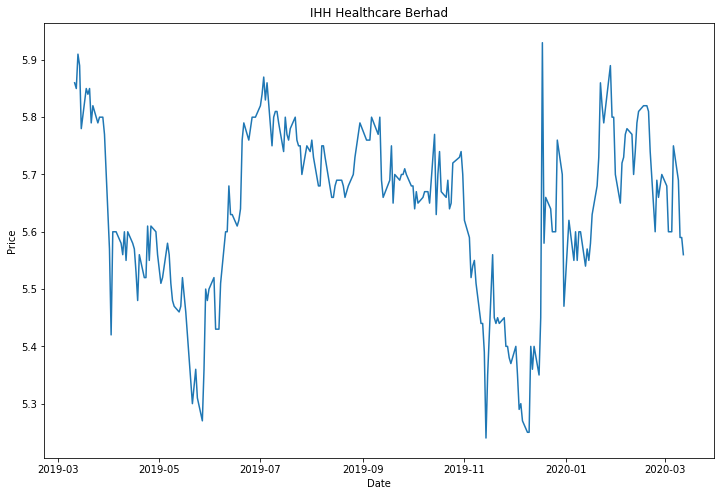

In [91]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
#plot the data
plt.figure(figsize=(12,8))
plt.plot(df['Close'])
plt.title("IHH Healthcare Berhad")
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [92]:
#get the values of close column and reshape it into an array
close_data = df['Close'].values
close_data = close_data.reshape((-1,1))
#set split percentage to 80%
split_percent = 0.80
split = int(split_percent*len(close_data))
#split close column
close_train = close_data[:split]
close_test = close_data[split:]
#split date column
date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

201
51


In [93]:
#number of previous days' data to use, to predict the value for the next day
look_back = 15

#TimeseriesGenerator is function takes in data points and generate batches of temporal data for training or validation.
train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)


In [94]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
#use adam optimiser and mean squared loss function for 25 epochs
model.compile(optimizer='adam', loss='mse')

num_epochs = 25
#use fit_generator as data generator is used
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/25
10/10 [==============================] - 2s 184ms/step - loss: 75.6031
Epoch 2/25
10/10 [==============================] - 0s 31ms/step - loss: 63.8262
Epoch 3/25
10/10 [==============================] - 0s 29ms/step - loss: 53.9803
Epoch 4/25
10/10 [==============================] - 0s 35ms/step - loss: 44.6065
Epoch 5/25
10/10 [==============================] - 0s 37ms/step - loss: 32.2368
Epoch 6/25
10/10 [==============================] - 0s 38ms/step - loss: 9.9179
Epoch 7/25
10/10 [==============================] - 0s 38ms/step - loss: 1.6224
Epoch 8/25
10/10 [==============================] - 0s 33ms/step - loss: 0.8572
Epoch 9/25
10/10 [==============================] - 0s 34ms/step - loss: 0.1701
Epoch 10/25
10/10 [==============================] - 0s 39ms/step - loss: 0.0620
Epoch 11/25
10/10 [==============================] - 0s 38ms/step - loss: 0.0440
Epoch 12/25
10/10 [==============================] - 0s 39ms/step - loss: 0.0316
Epoch 13/25
10/10 [============

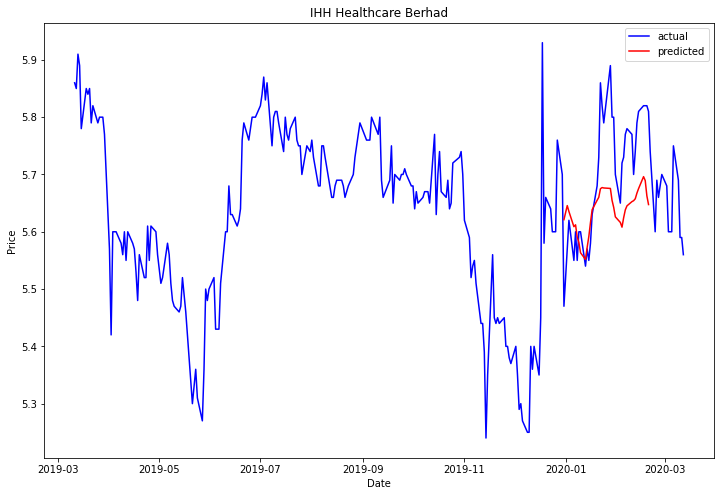

In [95]:
prediction = model.predict_generator(test_generator)

#reshape it back for plotting
close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

#plot the graph with the predicted value
plt.figure(figsize=(12,8))
plt.plot(df['Close'], color='blue')
plt.plot(date_test[:len(prediction)], prediction, color='red')
plt.legend(['actual','predicted'])
plt.title("IHH Healthcare Berhad")
plt.xlabel('Date')
plt.ylabel('Price')
#plt.plot(date_test[:len(close_test)], close_test, color='green')


plt.show()


In [96]:
#Calculate mean squared loss
model.evaluate(test_generator)

36/36 [==============================] - 0s 11ms/step


0.007656266912817955

In [97]:
close_data = close_data.reshape((-1))
#forecasting by feed the model past n days (look_back) and get future's value, to get days after the predicted future, the model is feed in pat n-1 days of value along with the predicted value
def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

#predict 30 days
num_prediction = 30
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

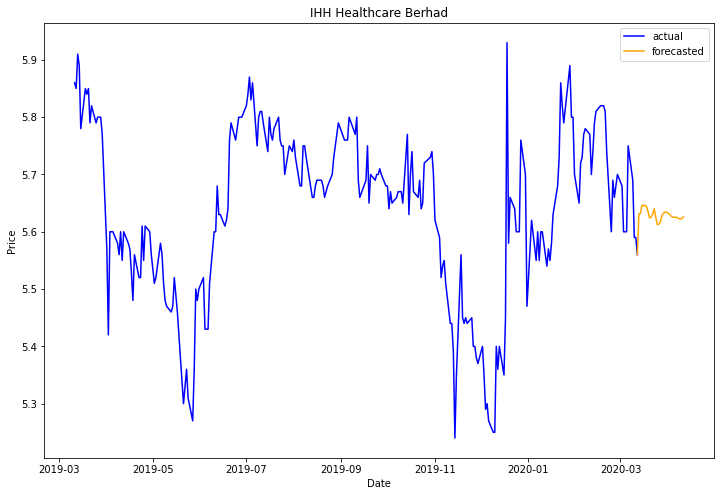

In [98]:
#plot the data with the predicted 30 days
plt.figure(figsize=(12,8))
plt.plot(df['Close'], color='blue')
plt.plot(forecast_dates[:len(forecast)],forecast,color='orange')
plt.legend(['actual','forecasted'])
plt.title("IHH Healthcare Berhad")
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [99]:
#get the prediction for 1 year
num_prediction = 365
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)
    
forecast[-1]

5.626041412353516